In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot
from functools import partial

In [3]:
dt.config()

In [4]:
lc = 0.2
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

print(down_bnd_edges_idx)
print(up_bnd_edges_idx)

[0, 12, 15, 18, 3]
[7, 34, 37, 40, 9]


In [6]:
mu_ = 1.
lambda_ = 10.
gamma_ = 0.2
tau_ = mu_*gamma_
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] += gamma_*S.node_coords[:, 1]
up_bnd_pos_components = [0]

up_bnd_nodes_pos_x = true_curr_node_coords[up_bnd_nodes_idx, up_bnd_pos_components]
up_bnd_nodes_pos_y = ref_node_coords[up_bnd_nodes_idx, 1]
down_bnd_pos = ref_node_coords[down_bnd_nodes_idx, :]

In [41]:
# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
boundary_values = {"0": (up_bnd_nodes_idx, up_bnd_nodes_pos_x),
                   ":": (down_bnd_nodes_idx, down_bnd_pos)}
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 100000.
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
#f = np.zeros((S.num_nodes, (embedded_dim-1)), dtype=dt.float_dtype)
curr_node_coords = jnp.full(
    S.node_coords.shape, jnp.nan, dtype=dt.float_dtype)
#obj = ela.obj_linear_elasticity_energy
obj = ela.obj_linear_elasticity_primal
x0 = S.node_coords.flatten()
# x0 = true_curr_node_coords.flatten()

#unknown_node_coords = S.node_coords.copy()
#unknown_node_coords[up_bnd_nodes_idx , 0] = np.nan
#unknown_node_coords[down_bnd_nodes_idx, :] = np.nan
#unknown_node_coords_flattened = unknown_node_coords.flatten()
#unknown_node_idx = ~np.isnan(unknown_node_coords_flattened)
#x0 = unknown_node_coords_flattened[unknown_node_idx]
#obj = partial(ela.obj_linear_elasticity_dual,
#                          unknown_node_idx=unknown_node_idx)


# traction bcs
idx_left_right_edges = left_bnd_edges_idx + right_bnd_edges_idx
bnd_tractions_up = np.zeros(len(up_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left = tau_*np.ones(len(left_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_right = -tau_*np.ones(len(right_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_left_right = np.zeros(len(idx_left_right_edges), dtype = dt.float_dtype)
idx_tract_y = up_bnd_edges_idx + idx_left_right_edges
bnd_tractions_y = np.concatenate((bnd_tractions_up, bnd_tractions_left, bnd_tractions_right))

boundary_tractions = {'1': (idx_tract_y, bnd_tractions_y),
                     '0': (idx_left_right_edges, bnd_tractions_left_right)}
#obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}
#obj_args = {'f': f,
#            'boundary_values': boundary_values,
#            'boundary_tractions': boundary_tractions,
#            'curr_node_coords': curr_node_coords}
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values, 'boundary_tractions': boundary_tractions}

In [33]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-9, ftol_rel=1e-9, maxeval = 10000)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)
#print(len(sol))
#curr_node_coords = ela.set_displacement_bc(curr_node_coords, boundary_values)
#curr_node_coords_flattened = curr_node_coords.flatten()
#curr_node_coords_flattened = curr_node_coords_flattened.at[jnp.isnan(
#    curr_node_coords_flattened)].set(sol)
#curr_node_coords = curr_node_coords_flattened.reshape(S.node_coords.shape)

Traced<ShapedArray(float64[66,2])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float64[66,2])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[66,2])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[66,2])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[66,2]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f42572f83f0>, in_tracers=(Traced<ShapedArray(float64[66,2]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x7f425731e700; to 'JaxprTracer' at 0x7f425731c2c0>], out_avals=[ShapedArray(float64[66,2])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[66,2]. let  in (a,) }, 'in_shardings': (UnspecifiedValue,), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False,), 'name': 'fn', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f42b86994f0>, name_stack=NameStack(stack=(Transform(

In [40]:
print(obj(sol, f, gamma, boundary_values, boundary_tractions))
print(obj(true_curr_node_coords.flatten(), f, gamma, boundary_values, boundary_tractions))

[[ 5.71988222e-02  2.08905123e-02]
 [ 1.84032498e-02 -2.13008124e-02]
 [-2.62632447e-02  4.60822217e-02]
 [ 7.06361333e-02 -2.64625618e-02]
 [-2.04941370e-02 -4.34475725e-03]
 [-5.32403268e-02 -4.28082470e-02]
 [-3.64290448e-02  5.20608530e-02]
 [-2.92188436e-02 -1.99208672e-02]
 [-5.83053176e-03 -1.86195421e-03]
 [ 2.19992945e-03  3.02430541e-01]
 [ 2.01413730e-02  8.49451618e-03]
 [-2.13435672e-04 -2.68104040e-01]
 [ 1.72540508e-02  1.27521277e-02]
 [ 1.47670337e-03 -7.02481781e-03]
 [ 1.18100292e-02 -3.63277539e-03]
 [-2.71076232e-02  3.22140151e-01]
 [-3.31156877e-03  1.58327104e-02]
 [ 3.00928735e-02 -3.30033169e-01]
 [-2.14285276e-03  2.24548547e-02]
 [-5.31272648e-04  1.95439882e-02]
 [ 2.55266259e-03  3.87274174e-02]
 [-2.54836414e-02  2.97953166e-01]
 [ 1.19061942e-02 -2.49868484e-02]
 [-1.51703836e-02  2.28660904e-03]
 [-2.58997468e-02  5.11853688e-02]
 [ 1.46959145e-02 -2.72398749e-01]
 [ 9.80225890e-03 -1.21644360e-02]
 [-1.71517205e-03 -2.81939164e-02]
 [ 1.91367086e-03  4

In [34]:
strain = ela.get_infinitesimal_strain(curr_node_coords)
stress = ela.get_stress(strain)

print("strain=", strain)
print("stress=", stress)

strain= [[[ 1.06354554e-01  2.48660366e-02]
  [ 2.48660366e-02 -1.26228181e-01]]

 [[-1.48718431e-02 -2.48134329e-02]
  [-2.48134329e-02 -1.73307971e-02]]

 [[ 7.79845314e-03 -1.13241441e-02]
  [-1.13241441e-02 -6.37265770e-03]]

 [[-1.18146755e-01  8.68553730e-03]
  [ 8.68553730e-03  1.51650873e-01]]

 [[ 3.87489496e-02  6.02766687e-02]
  [ 6.02766687e-02 -2.92595992e-02]]

 [[-1.66676198e-01  2.50416957e-02]
  [ 2.50416957e-02  1.50765065e-01]]

 [[ 1.40646008e-01 -1.39692866e-02]
  [-1.39692866e-02 -1.32806483e-01]]

 [[ 4.40154861e-03 -3.84992897e-02]
  [-3.84992897e-02 -1.88942272e-04]]

 [[ 4.37622957e-02  2.10644222e-02]
  [ 2.10644222e-02 -3.66355930e-02]]

 [[ 1.37241367e-01 -1.85527393e-01]
  [-1.85527393e-01 -1.69197009e-01]]

 [[ 1.99817507e-05  7.39740405e-02]
  [ 7.39740405e-02  7.72144483e-03]]

 [[-2.00741737e-01 -1.56509165e-01]
  [-1.56509165e-01  2.69452620e-01]]

 [[ 1.57231695e-02  8.73434877e-02]
  [ 8.73434877e-02 -2.86559992e-02]]

 [[ 7.91811623e-06 -1.08729851

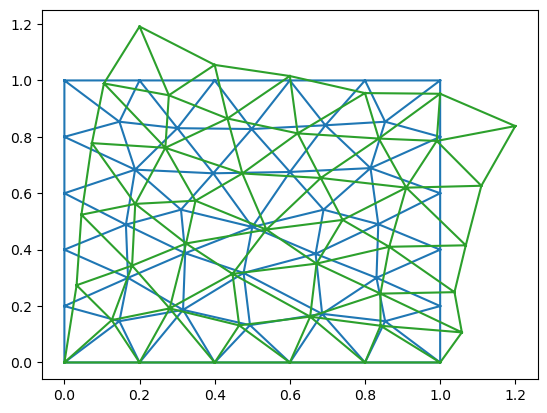

In [35]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [64]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values))
print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values))
node_coords_coch = C.CochainP0(complex=S, coeffs=curr_node_coords)
f_coch = C.CochainP2(complex=S, coeffs=f)
elastic_energy = ela.elasticity_energy(node_coords_coch, f_coch)
print(elastic_energy)

0.03304982361147039
0.04000000000000001
0.03304982361147039


In [65]:
print(true_curr_node_coords)
print(curr_node_coords)

[[0.         0.         0.        ]
 [1.         0.         0.        ]
 [1.2        1.         0.        ]
 [0.2        1.         0.        ]
 [0.2        0.         0.        ]
 [0.4        0.         0.        ]
 [0.6        0.         0.        ]
 [0.8        0.         0.        ]
 [1.04       0.2        0.        ]
 [1.08       0.4        0.        ]
 [1.12       0.6        0.        ]
 [1.16       0.8        0.        ]
 [1.         1.         0.        ]
 [0.8        1.         0.        ]
 [0.6        1.         0.        ]
 [0.4        1.         0.        ]
 [0.16       0.8        0.        ]
 [0.12       0.6        0.        ]
 [0.08       0.4        0.        ]
 [0.04       0.2        0.        ]
 [0.26143963 0.48866509 0.        ]
 [0.93340959 0.49029969 0.        ]
 [0.52039366 0.13237604 0.        ]
 [0.66391313 0.82773866 0.        ]
 [0.46688877 0.83070291 0.        ]
 [0.53030677 0.67073445 0.        ]
 [0.73530537 0.67551889 0.        ]
 [0.59607695 0.48038476 0.  